### Faça um breve análise exploratória do dataset

    - Verifique a quantidade de ocorrências por cada tipo

    - Plot as ocorrências no espaço, usando latitude e longitude

    - Plot a distribução das distâncias entre os pontos. Utilize a distância para dados geolocalizados no:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

    - Aplique uma outra análise que achar interessante

##  Para identificar regiões com alta taxas de crime, aplique os algoritmos de clusterização vistos DBSCAN 
    - (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) e clustering hieráquico         - (https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) sobre o dataset

    - Considere como atributos latitude e longitude das ocorrências. 

    - Varie os parâmetros de cada um dos algoritmos em pelo menos 3 valores diferentes. 

### Analise os resultados

    - Plot os dados, use uma cor diferente por cluster.



In [78]:
import pandas as pd
import numpy as np
import folium

from matplotlib import pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from sklearn.metrics.pairwise import haversine_distances as haversine
from sklearn.cluster import DBSCAN, hierarchical
from scipy.cluster.hierarchy import complete, dendrogram, cut_tree
from scipy.spatial.distance import pdist

## Lendo os dados

In [2]:
df = pd.read_csv("../../datasets/variados/Cluster-Crime-Maio.gzip", compression='gzip')
df.head()

,ID,FONTE,FLAGRANTE,NATUREZA DA OCORRÊNCIA,HISTÓRICO DA OCORRÊNCIA,LOCAL:,BAIRRO,SUSPEITO:,VEÍCULO:,VÍTIMA:,...,ARMA APREENDIDA:,MATERIAL APREENDIDO:,PLACA:,VÍTIMAS LESIONADAS:,SUSPEITOS:,HORA,MINUTO,DATA,LATITUDE,LONGITUDE
0,1,CIOPS,NÃO,MORTE - A BALA,"LOCAL: RUA CODO, JANGURUSSU. VÍTIMA: TIAGO S.P...","RUA CODO, JANGURUSSU",JANGURUSSU,nulo,nulo,TIAGO S,...,nulo,nulo,nulo,nulo,NÃO IDENTIFICADOS,10,37,01/05/17,-3.850046,-38.522390
1,2,CIOPS,NÃO,MORTE A BALA,"LOCAL: AV. LESTE OESTE, PIRAMBU. VÍTIMA: RAFAE...","AV. LESTE OESTE, PIRAMBU",PIRAMBU,nulo,nulo,RAFAEL RS,...,nulo,nulo,nulo,nulo,NÃO IDENTIFICADOS,11,50,01/05/17,-3.712388,-38.553322
2,3,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA TAILANDIA, GENIBAÚ. VÍTIMA: ISRAEL ...","RUA TAILANDIA, GENIBAU",GENIBAU,nulo,nulo,ISRAEL RA,...,nulo,nulo,nulo,nulo,NÃO IDENTIFICADOS,13,53,01/05/17,-3.758621,-38.604318
3,4,CIOPS,NÃO,MORTE A BALA,LOCAL: RUA DR JOAQUIM FROTA SAPIRANGA COITÉ. V...,RUA DR JOAQUIM FROTA SAPIRANGA COITE,RUA DR JOAQUIM FROTA SAPIRANGA COITE,nulo,nulo,DAVI M,...,nulo,nulo,nulo,nulo,NÃO IDENTIFICADOS,15,14,01/05/17,-3.801281,-38.472957
4,5,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA CARNAUBAL, ALVARO WEYNE. VÍTIMA: DI...","RUA CARNAUBAL, ALVARO WEYNE",ALVARO WEYNE,nulo,nulo,DIEGO T,...,nulo,nulo,nulo,nulo,NÃO IDENTIFICADOS,17,42,01/05/17,-3.722553,-38.582816


In [3]:
df.rename(columns={'ID': 'index'}, inplace=True)

### fazendo preprocessamento da coluna **Natureza da ocorrência**

In [4]:
def tipo(nome):
    if "MORTE" in nome:
        return 'homicidio'
    if "TRAFICO" in nome or "DROGAS" in nome:
        return 'trafico'
    if "PORTE" in nome or "APREEN" in nome or 'POSSE' in nome:
        return 'porte ilegal'
    if "FURTO" in nome:
        return 'furto'
    if "ROUBO" in nome:
        return 'roubo'
    if "LESAO" in nome or "ATROPELAMENTO" in nome:
        return 'agressão'
    if "VEICULO" in nome:
        return 'veiculo encontrado'
    
    return 'outros'

In [5]:
df['tipo'] = df['NATUREZA DA OCORRÊNCIA'].apply(lambda x: tipo(x))

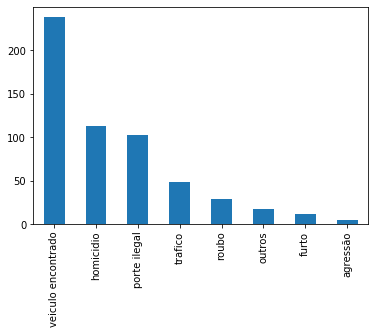

In [6]:
df['tipo'].value_counts().plot(kind='bar');

In [7]:
df['coord'] = df[['LATITUDE','LONGITUDE']].apply(tuple, axis=1)

In [8]:
coordenadaMedia = (df['LATITUDE'].mean(), df['LONGITUDE'].mean())
coordenadaMedia

(-3.7725928204585557, -38.546327830687815)

In [9]:
mapaDeCalor = folium.Map(coordenadaMedia, zoom_start=12, width='100%', height='100%')
mapaDeCalor.add_child(HeatMap(df['coord'], radius=15))
mapaDeCalor

In [10]:
mapaDePontos = folium.Map(coordenadaMedia, zoom_start=12, width='100%', height='100%')
mapaDePontos.add_child(FastMarkerCluster(df['coord']))
mapaDePontos

In [31]:
distancias_semi_vetoriais_entres_pontos = []
for i in df['coord']:
    distancias_de_um_ponto = df.apply(lambda x: haversine([[i[0], i[1]],[x['LATITUDE'], x['LONGITUDE']]])[0][1] * 6371000, axis=1)
    distancias_semi_vetoriais_entres_pontos.extend(distancias_de_um_ponto)

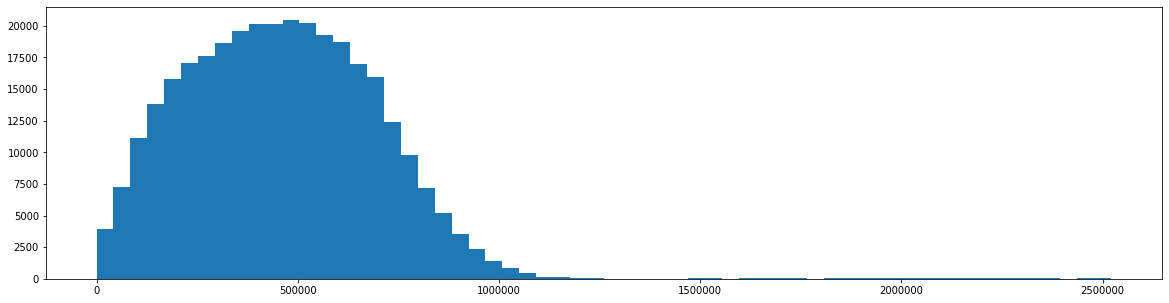

In [40]:
plt.figure(figsize=(20,5))
plt.hist(distancias_semi_vetoriais_entres_pontos, bins=60);

In [58]:
bairros_crimes = df['BAIRRO'].value_counts()
bairros_crimes = bairros_crimes[bairros_crimes > 5]

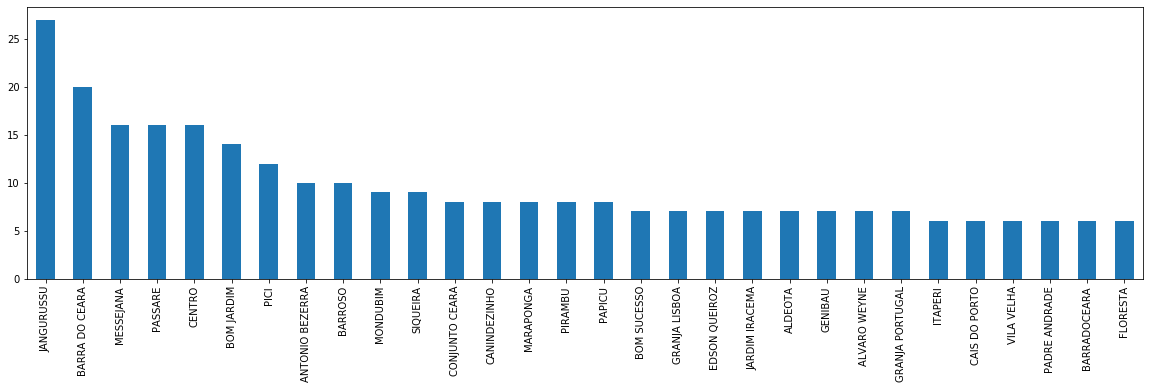

In [59]:
plt.figure(figsize=(20,5))
bairros_crimes.plot(kind='bar');

### Separando os dados

In [71]:
df.head()

,index,FONTE,FLAGRANTE,NATUREZA DA OCORRÊNCIA,HISTÓRICO DA OCORRÊNCIA,LOCAL:,BAIRRO,SUSPEITO:,VEÍCULO:,VÍTIMA:,...,PLACA:,VÍTIMAS LESIONADAS:,SUSPEITOS:,HORA,MINUTO,DATA,LATITUDE,LONGITUDE,tipo,coord
0,1,CIOPS,NÃO,MORTE - A BALA,"LOCAL: RUA CODO, JANGURUSSU. VÍTIMA: TIAGO S.P...","RUA CODO, JANGURUSSU",JANGURUSSU,nulo,nulo,TIAGO S,...,nulo,nulo,NÃO IDENTIFICADOS,10,37,01/05/17,-3.850046,-38.522390,homicidio,"(-3.850046, -38.52238970000001)"
1,2,CIOPS,NÃO,MORTE A BALA,"LOCAL: AV. LESTE OESTE, PIRAMBU. VÍTIMA: RAFAE...","AV. LESTE OESTE, PIRAMBU",PIRAMBU,nulo,nulo,RAFAEL RS,...,nulo,nulo,NÃO IDENTIFICADOS,11,50,01/05/17,-3.712388,-38.553322,homicidio,"(-3.712388, -38.5533215)"
2,3,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA TAILANDIA, GENIBAÚ. VÍTIMA: ISRAEL ...","RUA TAILANDIA, GENIBAU",GENIBAU,nulo,nulo,ISRAEL RA,...,nulo,nulo,NÃO IDENTIFICADOS,13,53,01/05/17,-3.758621,-38.604318,homicidio,"(-3.7586207, -38.6043184)"
3,4,CIOPS,NÃO,MORTE A BALA,LOCAL: RUA DR JOAQUIM FROTA SAPIRANGA COITÉ. V...,RUA DR JOAQUIM FROTA SAPIRANGA COITE,RUA DR JOAQUIM FROTA SAPIRANGA COITE,nulo,nulo,DAVI M,...,nulo,nulo,NÃO IDENTIFICADOS,15,14,01/05/17,-3.801281,-38.472957,homicidio,"(-3.8012815, -38.4729566)"
4,5,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA CARNAUBAL, ALVARO WEYNE. VÍTIMA: DI...","RUA CARNAUBAL, ALVARO WEYNE",ALVARO WEYNE,nulo,nulo,DIEGO T,...,nulo,nulo,NÃO IDENTIFICADOS,17,42,01/05/17,-3.722553,-38.582816,homicidio,"(-3.7225533, -38.582816)"


In [92]:
df = df[df['LONGITUDE'] < -38.35]

In [93]:
X = df.values[:, -4:-2]
X

array([[-3.850046, -38.52238970000001],
       [-3.712388, -38.5533215],
       [-3.7586207, -38.6043184],
       ...,
       [-3.7167538, -38.5656454],
       [-3.7440288, -38.59100110000001],
       [-3.7446345, -38.5311002]], dtype=object)

### Realizando a clusterização

#### DBSCAN

In [135]:
models = {}
epss = [0.011, 0.012, 0.013]
min_samples = [3, 5, 7]
for i in epss:
    for j in min_samples:
        models['DBSCAN_EPS_' + str(i) + '_MIN_SAMPLES_' + str(j)] = {'model': DBSCAN(eps=i, min_samples=j)}

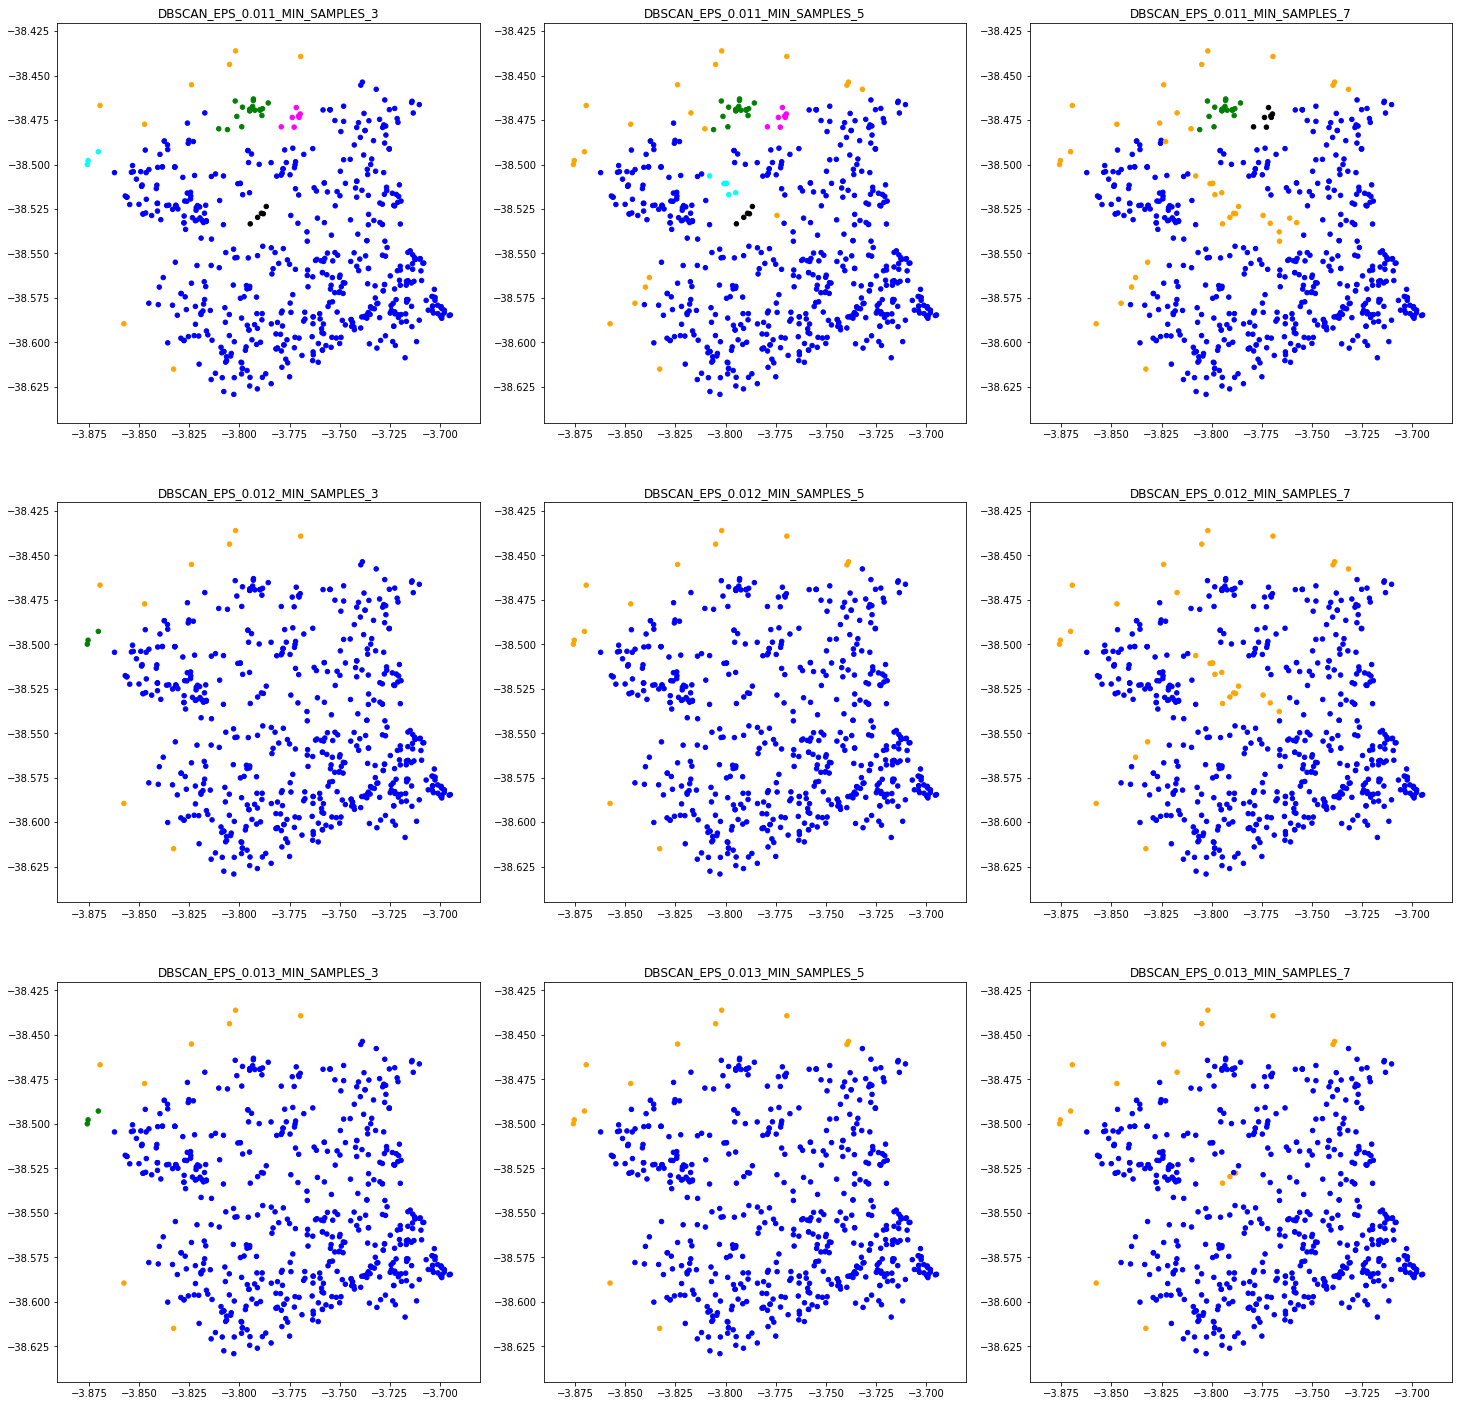

In [139]:
fig, axs = plt.subplots(3,3, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.15)

axs = axs.ravel()
colors = np.array(["blue", "green", "black", "magenta", "cyan", "purple", "orange"])
for index, item in enumerate(models):
    dbs = models[item]['model'].fit(X)
    axs[index].scatter(x=X[:, 0], y=X[:, 1], c=colors[dbs.labels_], s=20);
    axs[index].set_title(item)

In [ ]:
# Frustrante, mas foi o melhor que a minha paciêcia pemitiu criar

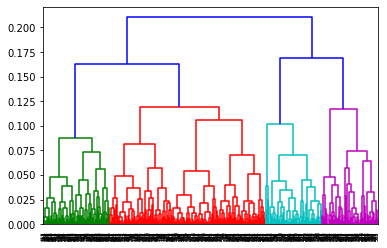

In [140]:
distance_matrix = pdist(X, metric='euclidean')
cluster_model = complete(distance_matrix)
dendogram = dendrogram(cluster_model)
sensor_cluster_list = cut_tree(cluster_model, n_clusters=2) 

# não entendi nada ;-;
Lívia socorro!!!

In [142]:
sensor_cluster_list.shape

(566, 1)

In [143]:
sensor_cluster_list = sensor_cluster_list.reshape(566,)

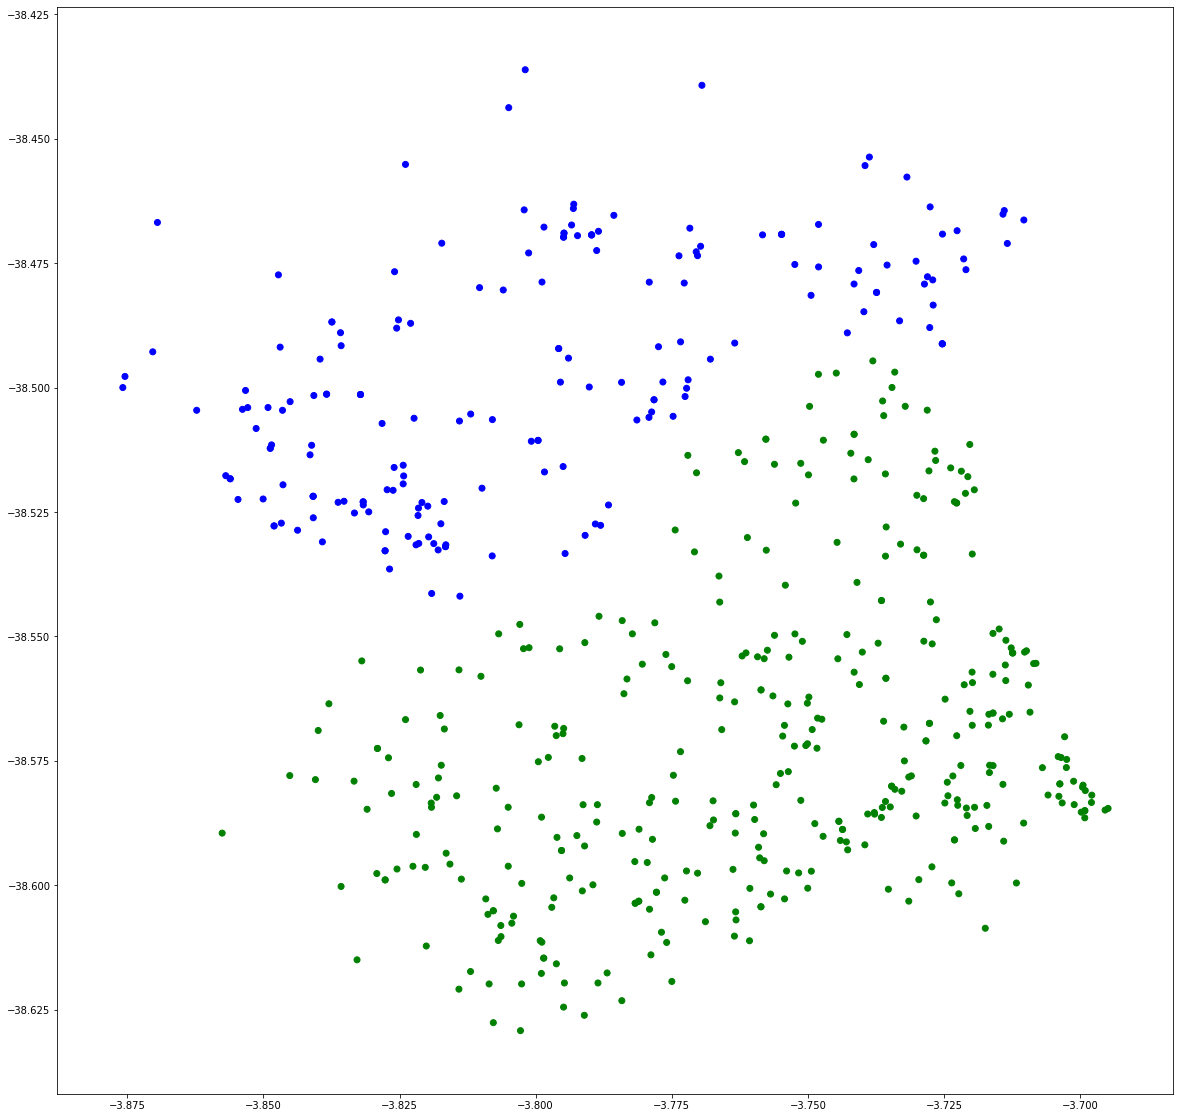

In [147]:
plt.figure(figsize=(20, 20))
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors[sensor_cluster_list], label='Clusters');